In [4]:
# use gpd_2023 environment

import sys

import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#import seaborn as sns
import pickle
#import torch

import cv2
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#sys.path.insert(0, "/home/projects/ku_00017/people/simpol/scripts/conflictNet/src/utils")
sys.path.insert(0, "/home/simon/Documents/scripts/conflictNet/src/utils")

In [5]:
print(np.__version__)
print(cv2.__version__)
print(gpd.__version__)

1.22.3
4.6.0
0.12.2


In [6]:
# for the patches thing you really only need the views_vol

def get_data():

    local_dir_pro = '/home/simon/Documents/scripts/conflictNet/data/processed'


    with open(f'{local_dir_pro}/viewser_monthly_vol_test_sbnsos.pkl', 'rb') as file: 
        views_vol = pickle.load(file)

    return views_vol


#index_dict = {'pg_id' : 0, 'xcoord' : 1, 'ycoord' : 2, 'month_id' : 3, 'c_id' : 4, 'ln_sb_best' : 5, 'ln_ns_best' : 6, 'ln_os_best': 7}


In [7]:
def condence_grid(views_vol):
    grid = views_vol[:,:,:,5:].sum(axis = 3).sum(axis = 0) #. % and onwards are the 3 types of violence. Then, sum first over types of violence, then over months
    grid = np.sqrt(grid) # take square root to make it more visible

    return grid

In [8]:
# Adapted for viz from utils

def get_window_index(views_vol, intensity = 0.8):

    views_vol_count = np.count_nonzero(views_vol[:,:,:,5], axis = 0)# just use 5 (SB) for viz.

    min_events = views_vol_count.max()*intensity # just use 10 for viz 
    
    min_events_index = np.where(views_vol_count >= min_events) # number of events so >= 1 or > 0 is the same as np.nonzero

    min_events_row = min_events_index[0]
    min_events_col = min_events_index[1]

    min_events_indx = [(row, col) for row, col in zip(min_events_row, min_events_col)] 

    indx = min_events_indx[np.random.choice(len(min_events_indx))] # dumb but working solution of np.random instead of random

    window_index = {'row_indx':indx[0], 'col_indx':indx[1]} 

    return(window_index)


def get_window_coords(window_index):

    """Not really coords but the row and col indices of the window."""

    window_dim = 32 #for viz

    # Randomly select a window around the sampled index. np.clip is used to ensure that the window does not go out of bounds
    min_row_indx = np.clip(int(window_index['row_indx'] - np.random.randint(0, window_dim)), 0, 180 - window_dim)
    max_row_indx = min_row_indx + window_dim
    min_col_indx = np.clip(int(window_index['col_indx'] - np.random.randint(0, window_dim)), 0, 180 - window_dim)
    max_col_indx = min_col_indx + window_dim

    # make dict of window coords to return
    window_coords = {
        'min_row_indx':min_row_indx, 
        'max_row_indx':max_row_indx, 
        'min_col_indx':min_col_indx, 
        'max_col_indx':max_col_indx, 
        'dim':window_dim}

    return(window_coords)

In [9]:
def plot_grid(grid, views_vol, patches = 10, save = False):

    extent = (-25.75, 63.75, -46.75, 42.75)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(30, 20))

    # Plot the world map
    world.plot(ax=ax, color='none', edgecolor='black')

    # Set vmin and vmax for the image
    vmin = 0
    vmax = grid.max()

    im = ax.imshow(grid, extent=extent, vmin=vmin, vmax=vmax, cmap='rainbow', alpha=1)

    extent = im.get_extent()

    for i in range(patches):

        window_index = get_window_index(views_vol, 0.1)
        window_coords = get_window_coords(window_index)

        # Extract coordinates from the dictionary
        min_row, min_col, dim = window_coords['min_row_indx'], window_coords['min_col_indx'], window_coords['dim']

        min_lon =  (min_col/2) + extent[0] # divide by 2 because extent is in degrees and the grid is 0.5 degrees
        min_lat =  -((min_row/2) - extent[3] + 16) # a bit wieird becaues the grid is "upside down" compared to the tensor indices...
    
        # Draw a rectangle on the image
        rectangle = plt.Rectangle((min_lon, min_lat), dim/2, dim/2, linewidth=5, edgecolor='#ebb447ff', facecolor='none', alpha=0.5) # dim/2 because extent is in degrees and the grid is 0.5 degrees
        ax.add_patch(rectangle)

    # Remove borders and ticks
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if save:
        plt.savefig(f'/home/simon/Documents/scripts/conflictNet/reports/plots/patches.png', dpi=300, bbox_inches='tight')

    plt.show()



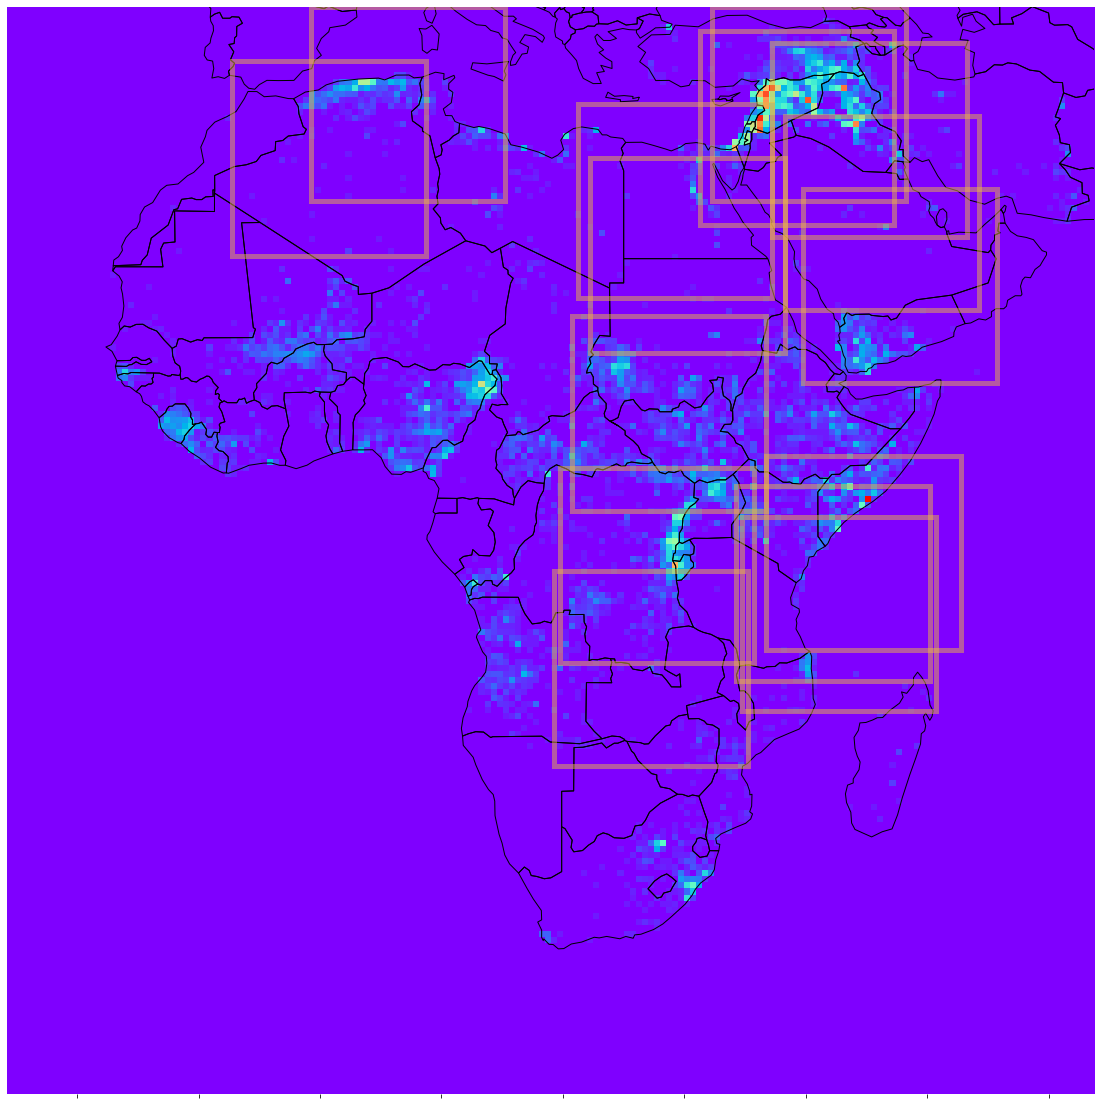

In [10]:
views_vol = get_data()
grid = condence_grid(views_vol)
plot_grid(grid, views_vol, 15, save = True)

In [11]:
def plot_grid_no_squares(grid, save = False):

    extent = (-25.75, 63.75, -46.75, 42.75)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(30, 20))

    # Plot the world map
    world.plot(ax=ax, color='none', edgecolor='black')

    # Set vmin and vmax for the image
    vmin = 0
    vmax = grid.max()

    im = ax.imshow(grid, extent=extent, vmin=vmin, vmax=vmax, cmap='rainbow', alpha=1)

    # Remove borders and ticks
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if save:
        plt.savefig(f'/home/simon/Documents/scripts/conflictNet/reports/plots/grid.png', dpi=300, bbox_inches='tight')

    plt.show()

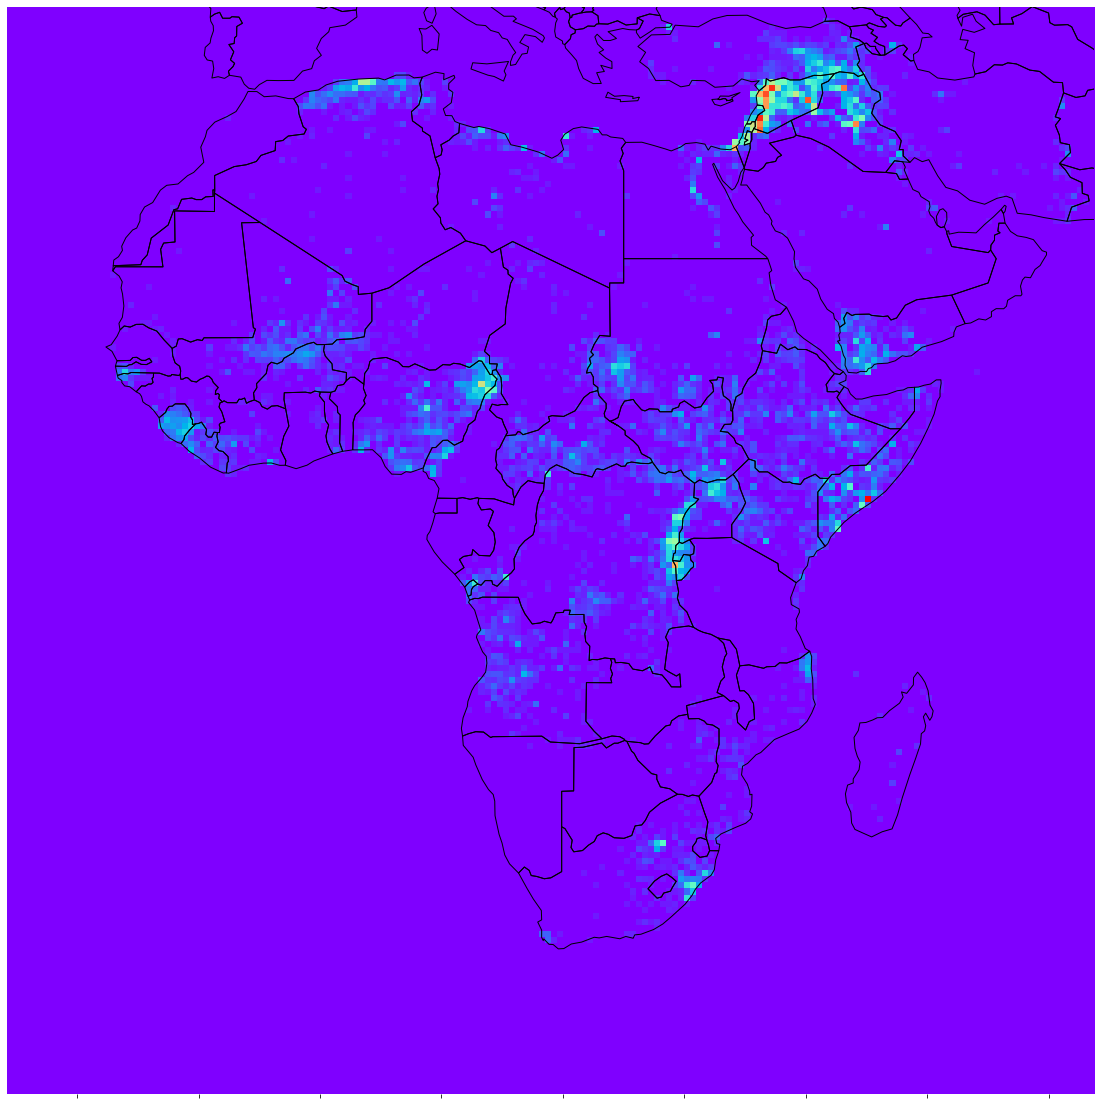

In [12]:
plot_grid_no_squares(grid, save = True)

In [15]:
def discard_ME_cells(un_masked_matrix, views_vol, feature):

    middle_east_c_id = [0.0]

    # Values to mask (0 and 1 in this example)
    values_to_mask = np.array(middle_east_c_id)

    # Create a mask for the specified values
    mask = np.isin(views_vol[-48, :, :, 4], values_to_mask)

    # Mask the array using the created mask
    masked_matrix = np.ma.masked_where(mask, un_masked_matrix[ :, :]) # [feature, :, :] is for the feature, i.e. type of violence

    return masked_matrix#vector



In [16]:
masked_matrix = discard_ME_cells(grid, views_vol, 0)

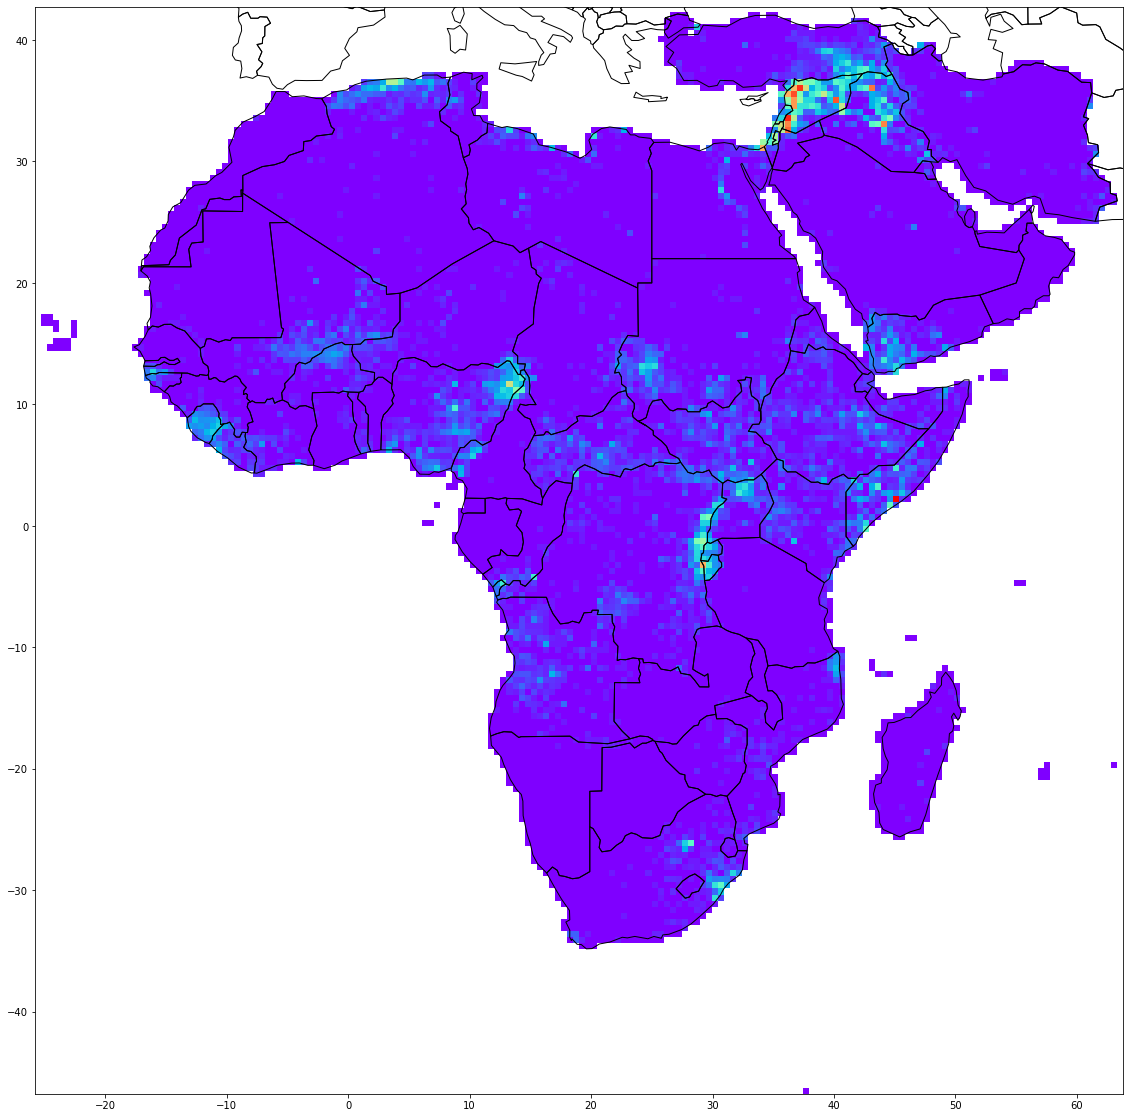

In [18]:
extent = (-25.75, 63.75, -46.75, 42.75)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(30, 20))

# Plot the world map
world.plot(ax=ax, color='none', edgecolor='black')

# Set vmin and vmax for the image
vmin = 0
vmax = grid.max()

ax.imshow(masked_matrix, extent=extent, vmin=vmin, vmax=vmax, cmap='rainbow', alpha=1)

plt.show()